In [198]:
################################################## Import necessary libraries ######################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from imblearn.under_sampling import RandomUnderSampler

from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb

# Filter warning messages
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Visualization settings
plt.rcParams["font.family"] = "Malgun Gothic"
plt.rcParams["axes.unicode_minus"] = False

# Problem Definition and Understanding

The goal of this project is to predict the loan grades for individuals in the test dataset based on the patterns learned from the training dataset. The training data contains historical information on loan grades, and we aim to develop a machine learning model that can effectively generalize from this historical data to accurately predict the loan grades for new, unseen individuals in the test set. The predictive model is trained using features such as employment length, loan purpose, and other relevant information available in the training dataset. The ultimate objective is to create a robust and accurate model that can contribute to making reliable predictions of loan grades for individuals who do not have known loan grades in the test dataset. The success of the project will be measured by the model's ability to provide accurate predictions on the test set, evaluated through metrics like accuracy, precision, recall, and F1-score.


## 0. Read the Data


In [138]:
# Read the training data from the "train.csv" file into a DataFrame called 'train'
train = pd.read_csv("train.csv")

# Read the test data from the "test.csv" file into a DataFrame called 'test'
test = pd.read_csv("test.csv")

## 1. Data Preprocessing


In [139]:
train.head(10)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수,대출등급
0,TRAIN_00000,12480000,36 months,6 years,RENT,72000000,18.90,15,부채 통합,0,0,0.0,0.0,0.0,C
1,TRAIN_00001,14400000,60 months,10+ years,MORTGAGE,130800000,22.33,21,주택 개선,0,373572,234060.0,0.0,0.0,B
2,TRAIN_00002,12000000,36 months,5 years,MORTGAGE,96000000,8.60,14,부채 통합,0,928644,151944.0,0.0,0.0,A
3,TRAIN_00003,14400000,36 months,8 years,MORTGAGE,132000000,15.09,15,부채 통합,0,325824,153108.0,0.0,0.0,C
4,TRAIN_00004,18000000,60 months,Unknown,RENT,71736000,25.39,19,주요 구매,0,228540,148956.0,0.0,0.0,B
5,TRAIN_00005,4800000,36 months,10+ years,RENT,84000000,13.78,30,휴가,0,240216,55428.0,0.0,0.0,A
6,TRAIN_00006,3600000,36 months,9 years,MORTGAGE,55200000,16.12,22,휴가,0,77892,46344.0,0.0,0.0,D
7,TRAIN_00007,12000000,60 months,2 years,RENT,66000000,14.73,45,부채 통합,0,557232,566136.0,0.0,0.0,C
8,TRAIN_00008,9840000,36 months,10+ years,OWN,45600000,20.27,11,의료,0,425928,266352.0,0.0,0.0,D
9,TRAIN_00009,2880000,36 months,2 years,RENT,72000000,10.02,26,자동차,0,268848,115572.0,0.0,0.0,C


In [140]:
train.shape

(96294, 15)

In [141]:
train.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,9.629400e+04,9.629400e+04,96294.000000,96294.000000,96294.000000,9.629400e+04,9.629400e+04,96294.000000,96294.000000
mean,1.830400e+07,9.392672e+07,19.379590,25.304827,0.345681,8.225035e+05,4.282282e+05,54.380584,0.005805
std,1.032908e+07,9.956871e+07,33.569559,12.088566,0.919119,1.027745e+06,4.402111e+05,1414.769218,0.079966
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+07,5.760000e+07,12.650000,17.000000,0.000000,3.075720e+05,1.346160e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.740000,24.000000,0.000000,5.976960e+05,2.870040e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.540000,32.000000,0.000000,1.055076e+06,5.702160e+05,0.000000,0.000000
max,4.200000e+07,1.080000e+10,9999.000000,169.000000,30.000000,4.195594e+07,5.653416e+06,75768.000000,4.000000


In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96294 entries, 0 to 96293
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            96294 non-null  object 
 1   대출금액          96294 non-null  int64  
 2   대출기간          96294 non-null  object 
 3   근로기간          96294 non-null  object 
 4   주택소유상태        96294 non-null  object 
 5   연간소득          96294 non-null  int64  
 6   부채_대비_소득_비율   96294 non-null  float64
 7   총계좌수          96294 non-null  int64  
 8   대출목적          96294 non-null  object 
 9   최근_2년간_연체_횟수  96294 non-null  int64  
 10  총상환원금         96294 non-null  int64  
 11  총상환이자         96294 non-null  float64
 12  총연체금액         96294 non-null  float64
 13  연체계좌수         96294 non-null  float64
 14  대출등급          96294 non-null  object 
dtypes: float64(4), int64(5), object(6)
memory usage: 11.0+ MB


In [143]:
test.head(10)

,ID,대출금액,대출기간,근로기간,주택소유상태,연간소득,부채_대비_소득_비율,총계좌수,대출목적,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
0,TEST_00000,16800000,36 months,8 years,MORTGAGE,132000000,19.64,12,주택 개선,0,394692,146604.0,0.0,0.0
1,TEST_00001,8400000,36 months,5 years,RENT,89971200,15.84,25,부채 통합,0,0,0.0,0.0,0.0
2,TEST_00002,17280000,36 months,6 years,RENT,150000000,8.41,20,신용 카드,0,1786980,281820.0,0.0,0.0
3,TEST_00003,14400000,36 months,5 years,MORTGAGE,66000000,13.72,30,신용 카드,1,669024,281724.0,0.0,0.0
4,TEST_00004,27600000,36 months,5 years,RENT,55200000,30.50,12,신용 카드,0,1250052,614844.0,0.0,0.0
5,TEST_00005,30000000,36 months,Unknown,MORTGAGE,180000000,30.10,50,신용 카드,0,1544304,249288.0,0.0,0.0
6,TEST_00006,24000000,60 months,10+ years,MORTGAGE,114000000,16.13,50,부채 통합,0,311904,182196.0,0.0,0.0
7,TEST_00007,7200000,36 months,Unknown,OWN,40800000,22.87,15,신용 카드,0,0,0.0,0.0,0.0
8,TEST_00008,28800000,60 months,3 years,RENT,114000000,27.70,46,부채 통합,0,763200,407916.0,0.0,0.0
9,TEST_00009,1350000,36 months,10+ years,RENT,48000000,16.80,7,기타,0,125832,54372.0,0.0,0.0


In [144]:
test.shape

(64197, 14)

In [145]:
test.describe()

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
count,6.419700e+04,6.419700e+04,64197.000000,64197.000000,64197.000000,6.419700e+04,6.419700e+04,64197.000000,64197.000000
mean,1.829630e+07,9.446378e+07,19.433747,25.295310,0.342882,8.231412e+05,4.324562e+05,50.313192,0.005499
std,1.038592e+07,1.117071e+08,40.375816,12.021127,0.901277,9.880161e+05,4.472797e+05,1396.384546,0.080020
min,1.200000e+06,0.000000e+00,0.000000,4.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.008000e+07,5.759880e+07,12.630000,17.000000,0.000000,3.081840e+05,1.343520e+05,0.000000,0.000000
50%,1.680000e+07,7.800000e+07,18.770000,24.000000,0.000000,5.986800e+05,2.875680e+05,0.000000,0.000000
75%,2.400000e+07,1.128000e+08,25.560000,32.000000,0.000000,1.061508e+06,5.774160e+05,0.000000,0.000000
max,4.200000e+07,1.044790e+10,9999.000000,135.000000,15.000000,4.049760e+07,5.645688e+06,108240.000000,4.000000


In [146]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64197 entries, 0 to 64196
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            64197 non-null  object 
 1   대출금액          64197 non-null  int64  
 2   대출기간          64197 non-null  object 
 3   근로기간          64197 non-null  object 
 4   주택소유상태        64197 non-null  object 
 5   연간소득          64197 non-null  int64  
 6   부채_대비_소득_비율   64197 non-null  float64
 7   총계좌수          64197 non-null  int64  
 8   대출목적          64197 non-null  object 
 9   최근_2년간_연체_횟수  64197 non-null  int64  
 10  총상환원금         64197 non-null  int64  
 11  총상환이자         64197 non-null  float64
 12  총연체금액         64197 non-null  float64
 13  연체계좌수         64197 non-null  float64
dtypes: float64(4), int64(5), object(5)
memory usage: 6.9+ MB


In [147]:
# Using the select_dtypes method from the pandas library to choose columns with data types "object" and "category".
cat_col = train.select_dtypes(include=["object", "category"]).columns.tolist()


cat_col

['ID', '대출기간', '근로기간', '주택소유상태', '대출목적', '대출등급']

In [148]:
# Iterating over a subset of categorical columns (columns 1 to 2) in the DataFrame 'train'.

for col in cat_col[1:3]:
    # Calculating the counts of each category in the selected column.
    category_counts = train[col].value_counts()

    # Printing the categories and their counts for the current column.
    print(f"{col} Categories:")
    print(category_counts)
    print()

대출기간 Categories:
 36 months    64479
 60 months    31815
Name: 대출기간, dtype: int64

근로기간 Categories:
10+ years    31585
2 years       8450
< 1 year      7774
3 years       7581
1 year        6249
Unknown       5671
5 years       5665
4 years       5588
8 years       4888
6 years       3874
7 years       3814
9 years       3744
10+years       896
<1 year        370
3               89
1 years         56
Name: 근로기간, dtype: int64



In [149]:
# Iterating over the remaining categorical columns (starting from column 3) in the DataFrame 'train'.

for col in cat_col[3:]:
    # Calculating the counts of each category in the selected column.
    category_counts = train[col].value_counts()

    # Printing the categories and their counts for the current column.
    print(f"{col} Categories:")
    print(category_counts)
    print()

주택소유상태 Categories:
MORTGAGE    47934
RENT        37705
OWN         10654
ANY             1
Name: 주택소유상태, dtype: int64

대출목적 Categories:
부채 통합     55150
신용 카드     24500
주택 개선      6160
기타         4725
주요 구매      1803
의료         1039
자동차         797
소규모 사업      787
이사          506
휴가          466
주택          301
재생 에너지       60
Name: 대출목적, dtype: int64

대출등급 Categories:
B    28817
C    27623
A    16772
D    13354
E     7354
F     1954
G      420
Name: 대출등급, dtype: int64



In [150]:
# train 데이터
train.loc[train["근로기간"] == "3", "근로기간"] = "3 years"
train.loc[train["근로기간"] == "1 year", "근로기간"] = "1 years"
train.loc[train["근로기간"] == "<1 year", "근로기간"] = "1 years"
train.loc[train["근로기간"] == "< 1 year", "근로기간"] = "1 years"
train.loc[train["근로기간"] == "10+years", "근로기간"] = "10+ years"

# test 데이터
test.loc[test["근로기간"] == "3", "근로기간"] = "3 years"
test.loc[test["근로기간"] == "1 year", "근로기간"] = "1 years"
test.loc[test["근로기간"] == "<1 year", "근로기간"] = "1 years"
test.loc[test["근로기간"] == "< 1 year", "근로기간"] = "1 years"
test.loc[test["근로기간"] == "10+years", "근로기간"] = "10+ years"

train["근로기간"].value_counts()
test["근로기간"].value_counts()

10+ years    21553
1 years       9676
2 years       5609
3 years       5085
5 years       3927
Unknown       3862
4 years       3662
8 years       3284
9 years       2545
7 years       2515
6 years       2479
Name: 근로기간, dtype: int64

## 2. Exploratory Data Analysis (EDA)


#### 1. Categorical Variables


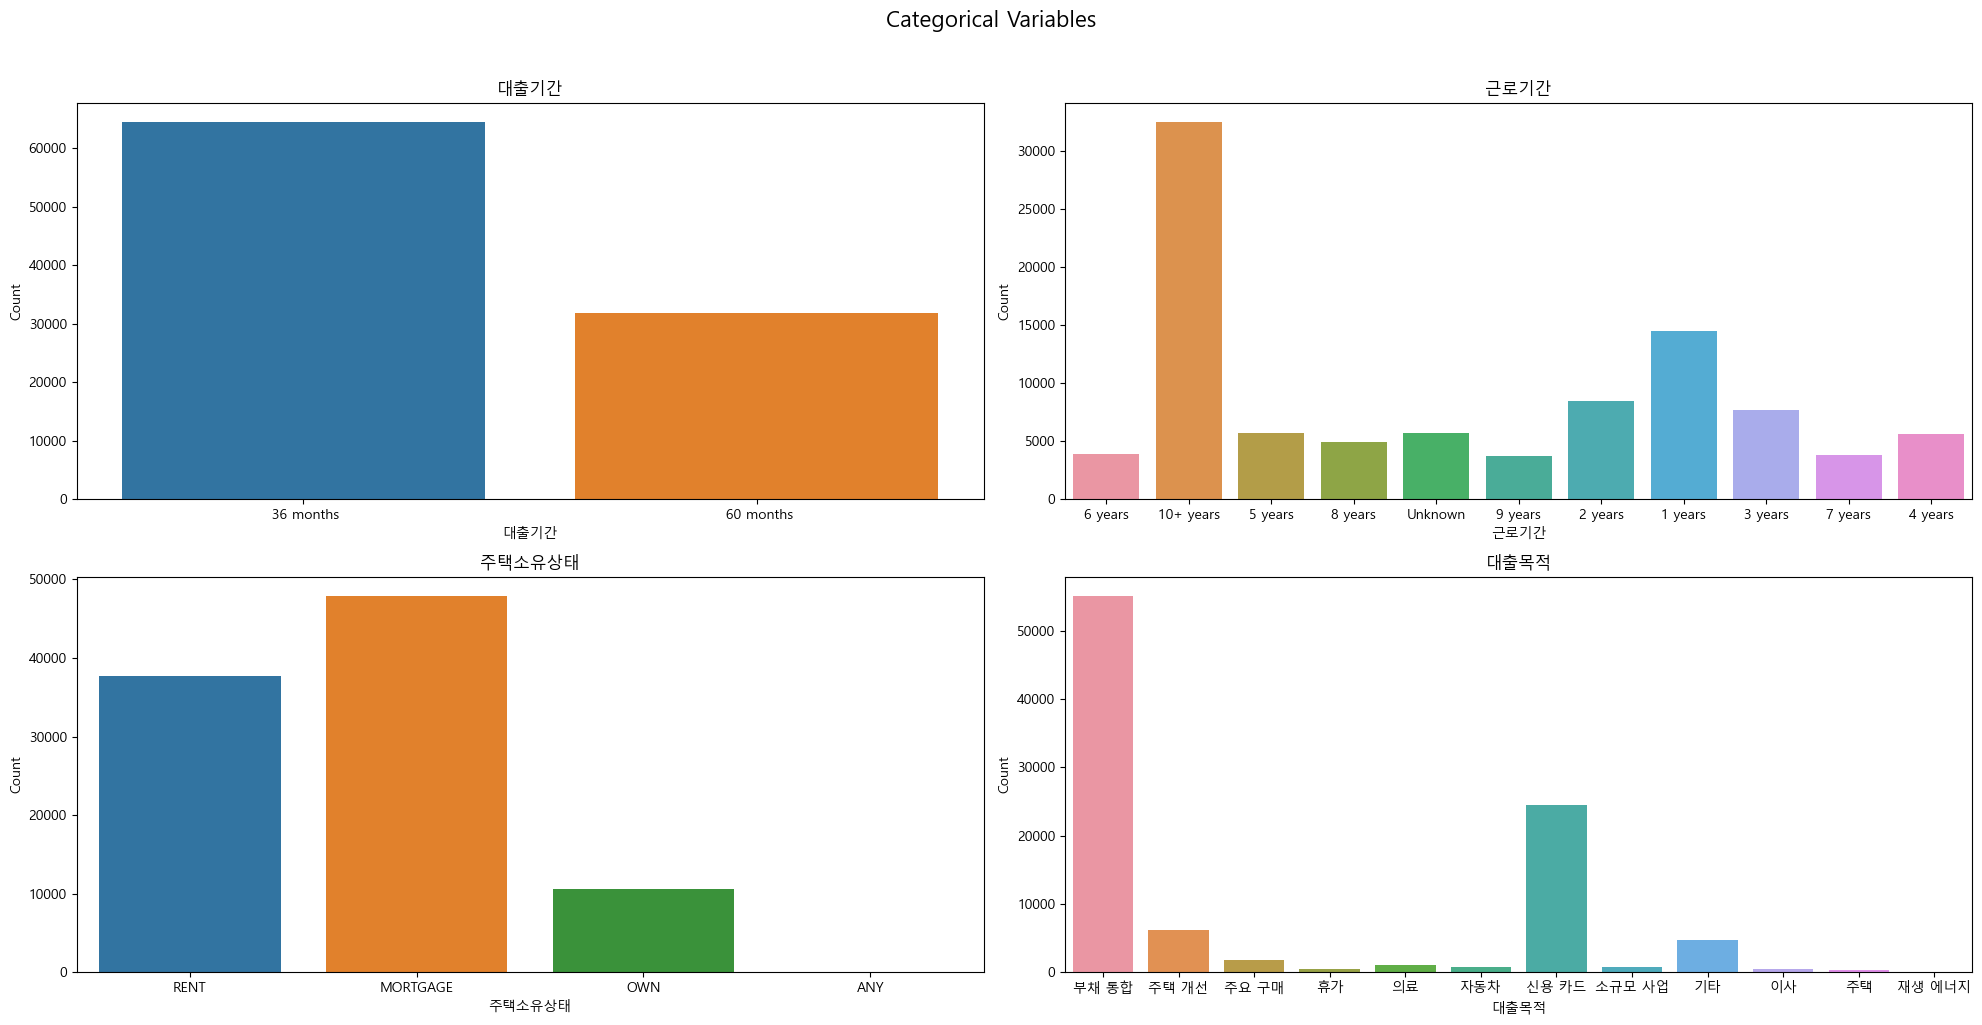

In [151]:
# Calculate the index to drop, the category columns (excluding the first and last)
drop_last = len(cat_col) - 1
category_col_name = cat_col[1:drop_last]

# Calculate the total number of categorical columns and rows needed for the subplot grid
total_category_cols = len(category_col_name)
rows = (total_category_cols + 1) // 2
cols = 2

# Set up the subplot grid
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 5))
fig.suptitle("Categorical Variables ", y=1.02, fontsize=16)

# Visualize count plots for each categorical variable
for i, c in enumerate(category_col_name):
    row = i // cols
    col = i % cols
    sns.countplot(data=train, x=c, ax=axes[row, col])
    axes[row, col].set_title(f"{c}")
    axes[row, col].set_xlabel(c)
    axes[row, col].set_ylabel("Count")

# Hide any remaining subplots if there are unused slots
for i in range(total_category_cols, rows * cols):
    row = i // cols
    col = i % cols
    fig.delaxes(axes[row, col])

# Adjust the layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

#### 2. Categorical Variables by the "대출등급"


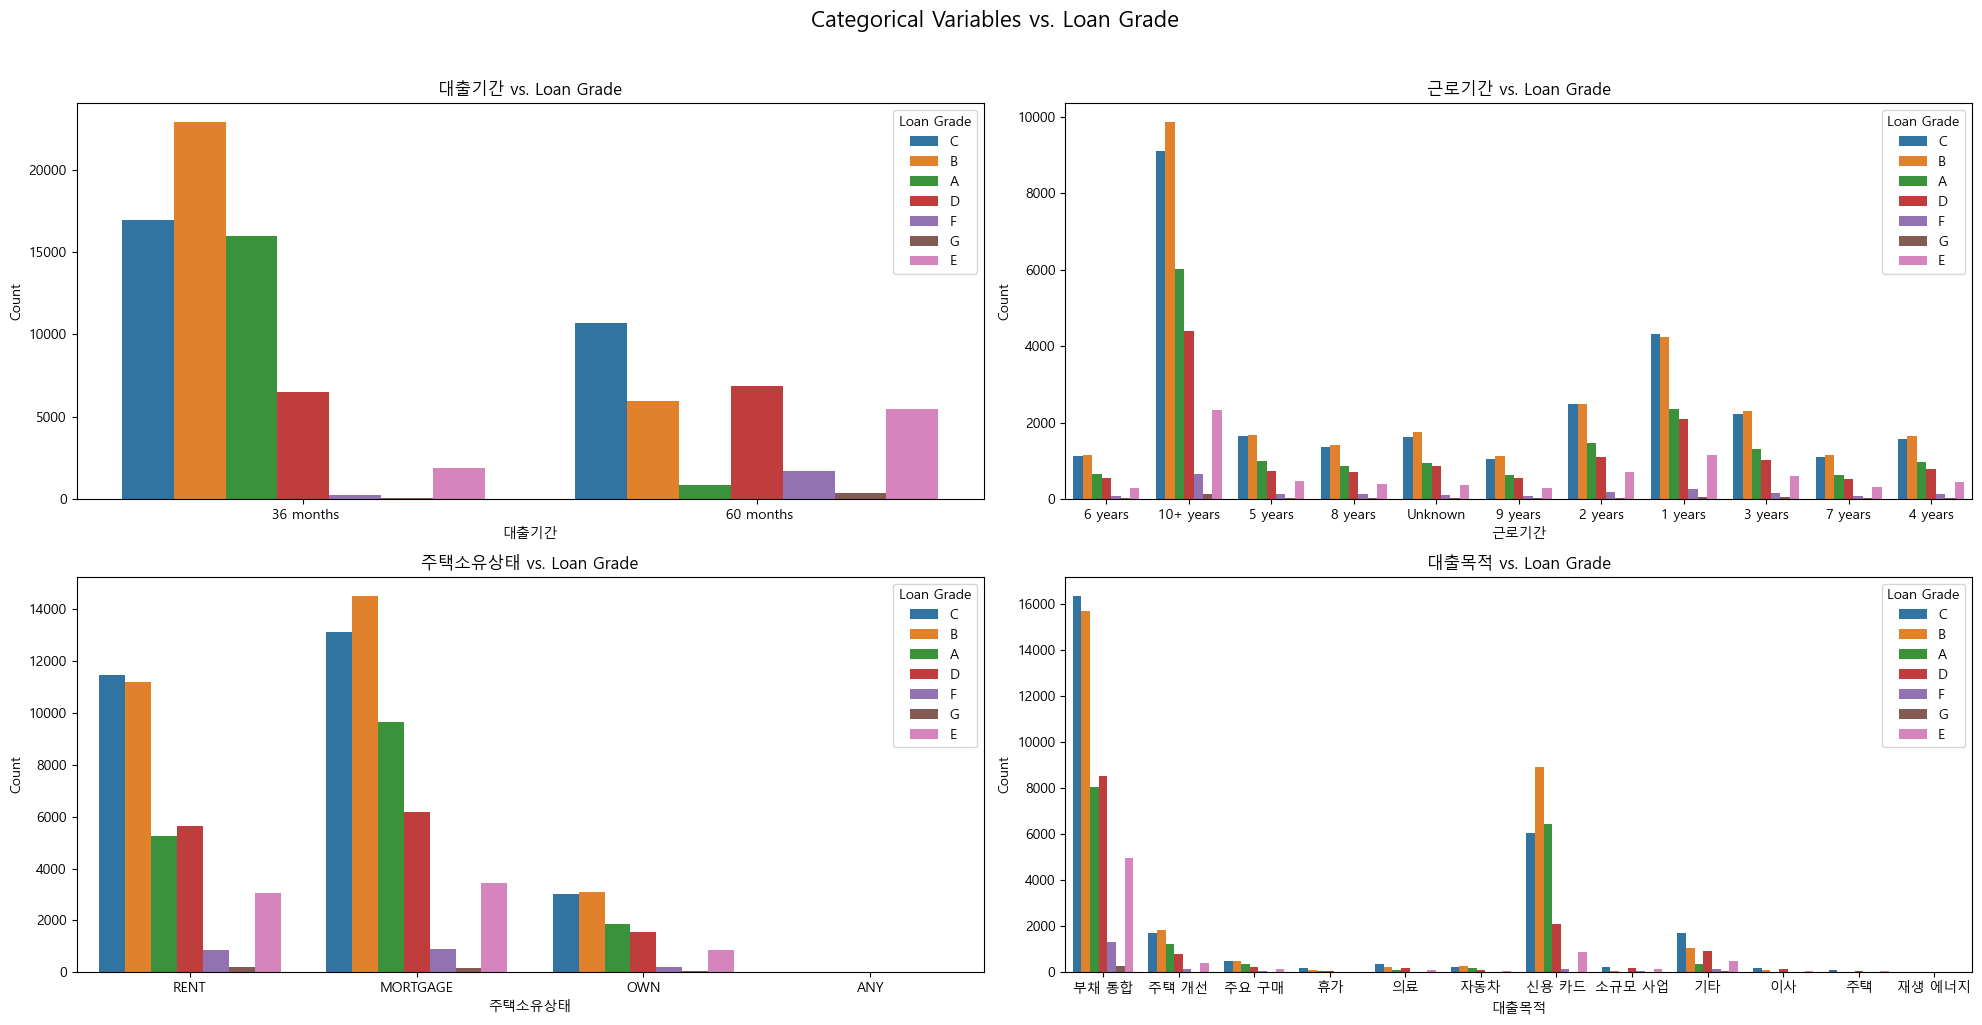

In [152]:
# Calculate the index to drop, the category columns (excluding the first and last)
drop_last = len(cat_col) - 1
category_col_name = cat_col[1:drop_last]

# Calculate the total number of categorical columns and rows needed for the subplot grid
total_category_cols = len(category_col_name)
rows = (total_category_cols + 1) // 2
cols = 2

# Set up the subplot grid
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, rows * 5))
fig.suptitle("Categorical Variables vs. Loan Grade", y=1.02, fontsize=16)

# Visualize count plots for each categorical variable with loan grade as hue
for i, c in enumerate(category_col_name):
    row = i // cols
    col = i % cols
    sns.countplot(data=train, x=c, hue="대출등급", ax=axes[row, col])
    axes[row, col].set_title(f"{c} vs. Loan Grade")
    axes[row, col].set_xlabel(c)
    axes[row, col].set_ylabel("Count")
    axes[row, col].legend(title="Loan Grade", loc="upper right")

# Hide any remaining subplots if there are unused slots
for i in range(total_category_cols, rows * cols):
    row = i // cols
    col = i % cols
    fig.delaxes(axes[row, col])

# Adjust the layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()

#### 3. Numerical Variables


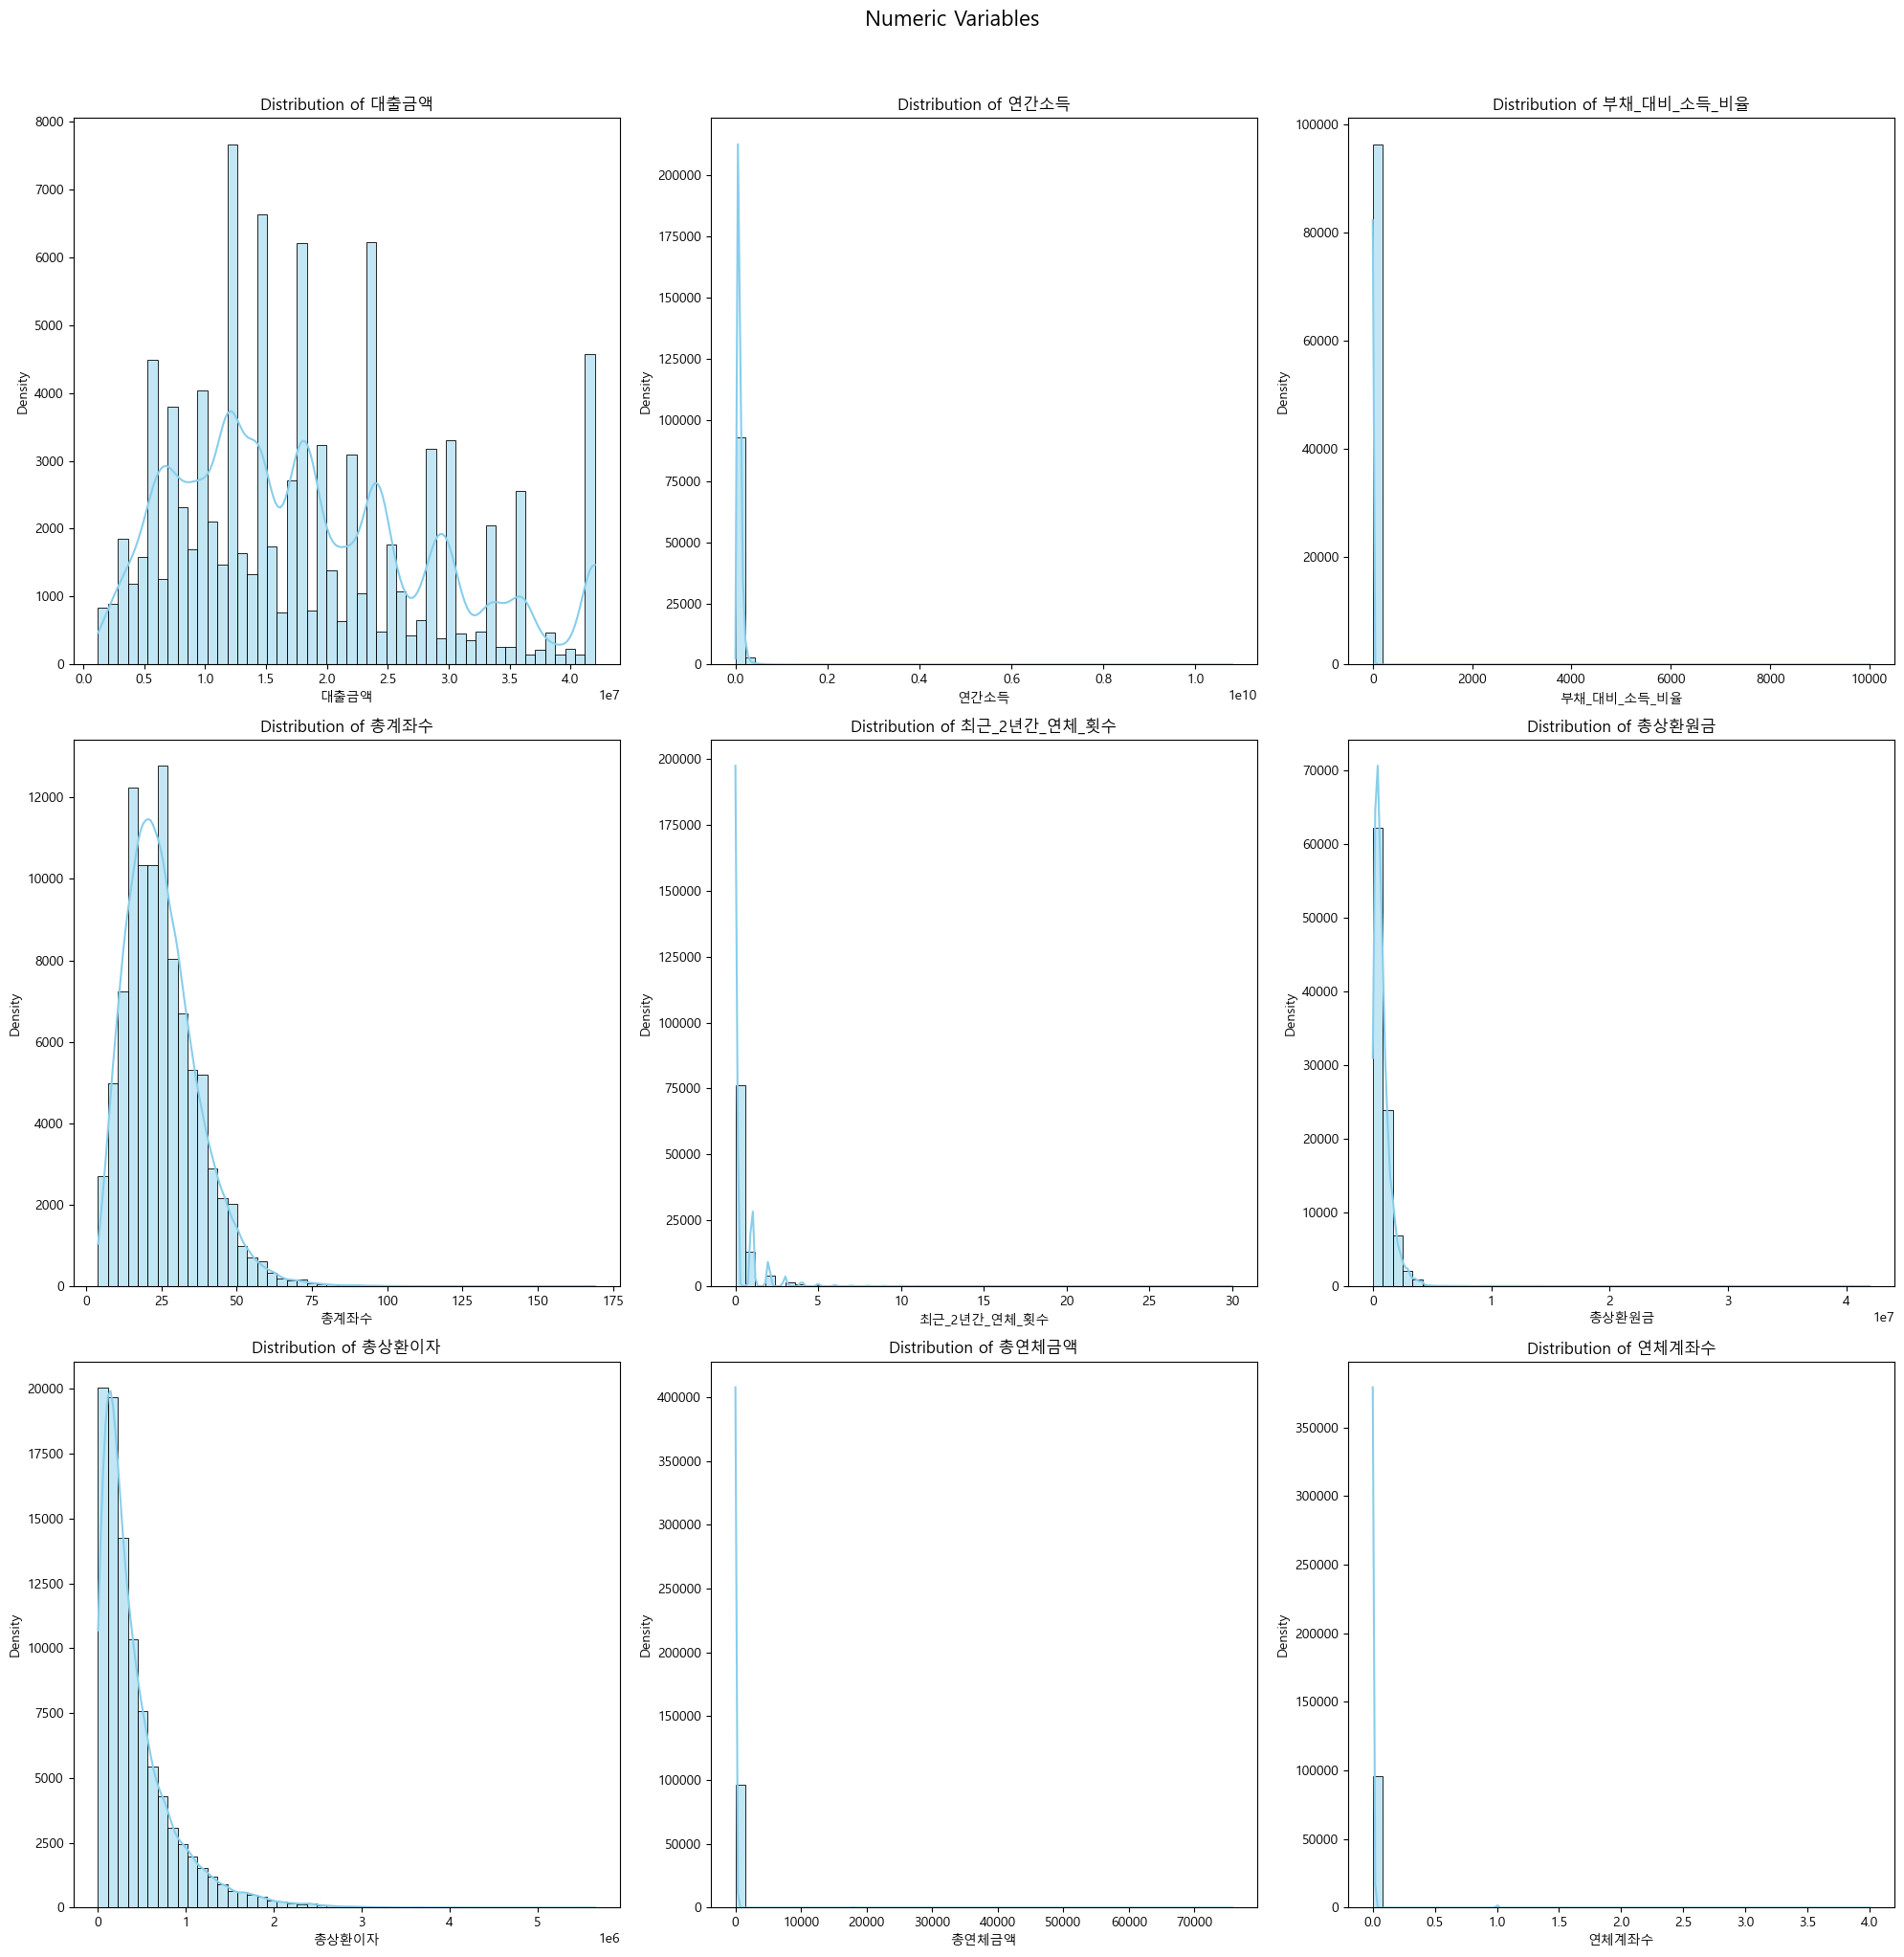

In [153]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select numeric columns
numeric_columns = train.select_dtypes(include=["number"]).columns
total_category_cols = len(numeric_columns)
rows = 3
cols = 3

# Set up the visualization
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20, 20))
fig.suptitle("Numeric Variables", y=1.02, fontsize=16)

# Visualize the distribution of numeric variables with respect to loan grade
for i, col_name in enumerate(numeric_columns):
    row = i // cols
    col = i % cols
    # Use histplot with adjusted bins, kde, and color
    sns.histplot(
        data=train,
        x=col_name,
        ax=axes[row, col],
        kde=True,
        bins=50,
        color="skyblue",
    )

    # Set title and labels for each subplot
    axes[row, col].set_title(f"Distribution of {col_name}")
    axes[row, col].set_xlabel(col_name)
    axes[row, col].set_ylabel("Density")

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

#### 4. Crorrelation among numercial varables


In [154]:
cor = train[numeric_columns].corr()
cor

,대출금액,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,총연체금액,연체계좌수
대출금액,1.000000,0.273975,0.002263,0.212309,-0.014775,0.379061,0.615680,0.011853,0.000182
연간소득,0.273975,1.000000,-0.044594,0.145403,0.040260,0.137552,0.114311,0.000333,0.009854
부채_대비_소득_비율,0.002263,-0.044594,1.000000,0.058830,0.000699,-0.016180,0.018565,0.000711,0.000051
총계좌수,0.212309,0.145403,0.058830,1.000000,0.112092,0.083615,0.116299,0.000037,0.023652
최근_2년간_연체_횟수,-0.014775,0.040260,0.000699,0.112092,1.000000,-0.010048,0.008095,0.004612,0.133632
총상환원금,0.379061,0.137552,-0.016180,0.083615,-0.010048,1.000000,0.412385,0.015379,-0.005190
총상환이자,0.615680,0.114311,0.018565,0.116299,0.008095,0.412385,1.000000,0.057838,0.009257
총연체금액,0.011853,0.000333,0.000711,0.000037,0.004612,0.015379,0.057838,1.000000,0.006620
연체계좌수,0.000182,0.009854,0.000051,0.023652,0.133632,-0.005190,0.009257,0.006620,1.000000


<AxesSubplot: >

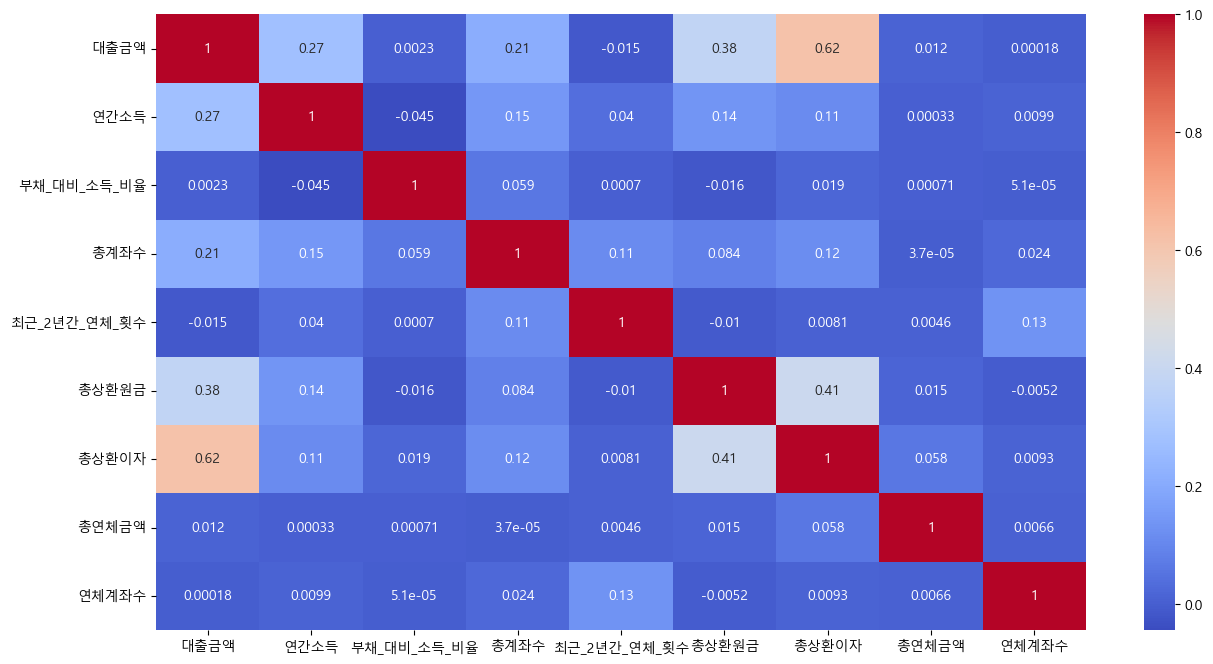

In [155]:
plt.figure(figsize=(15, 8))
sns.heatmap(cor, annot=True, cmap="coolwarm")

#### 5. Scattor Plot among numerical variables


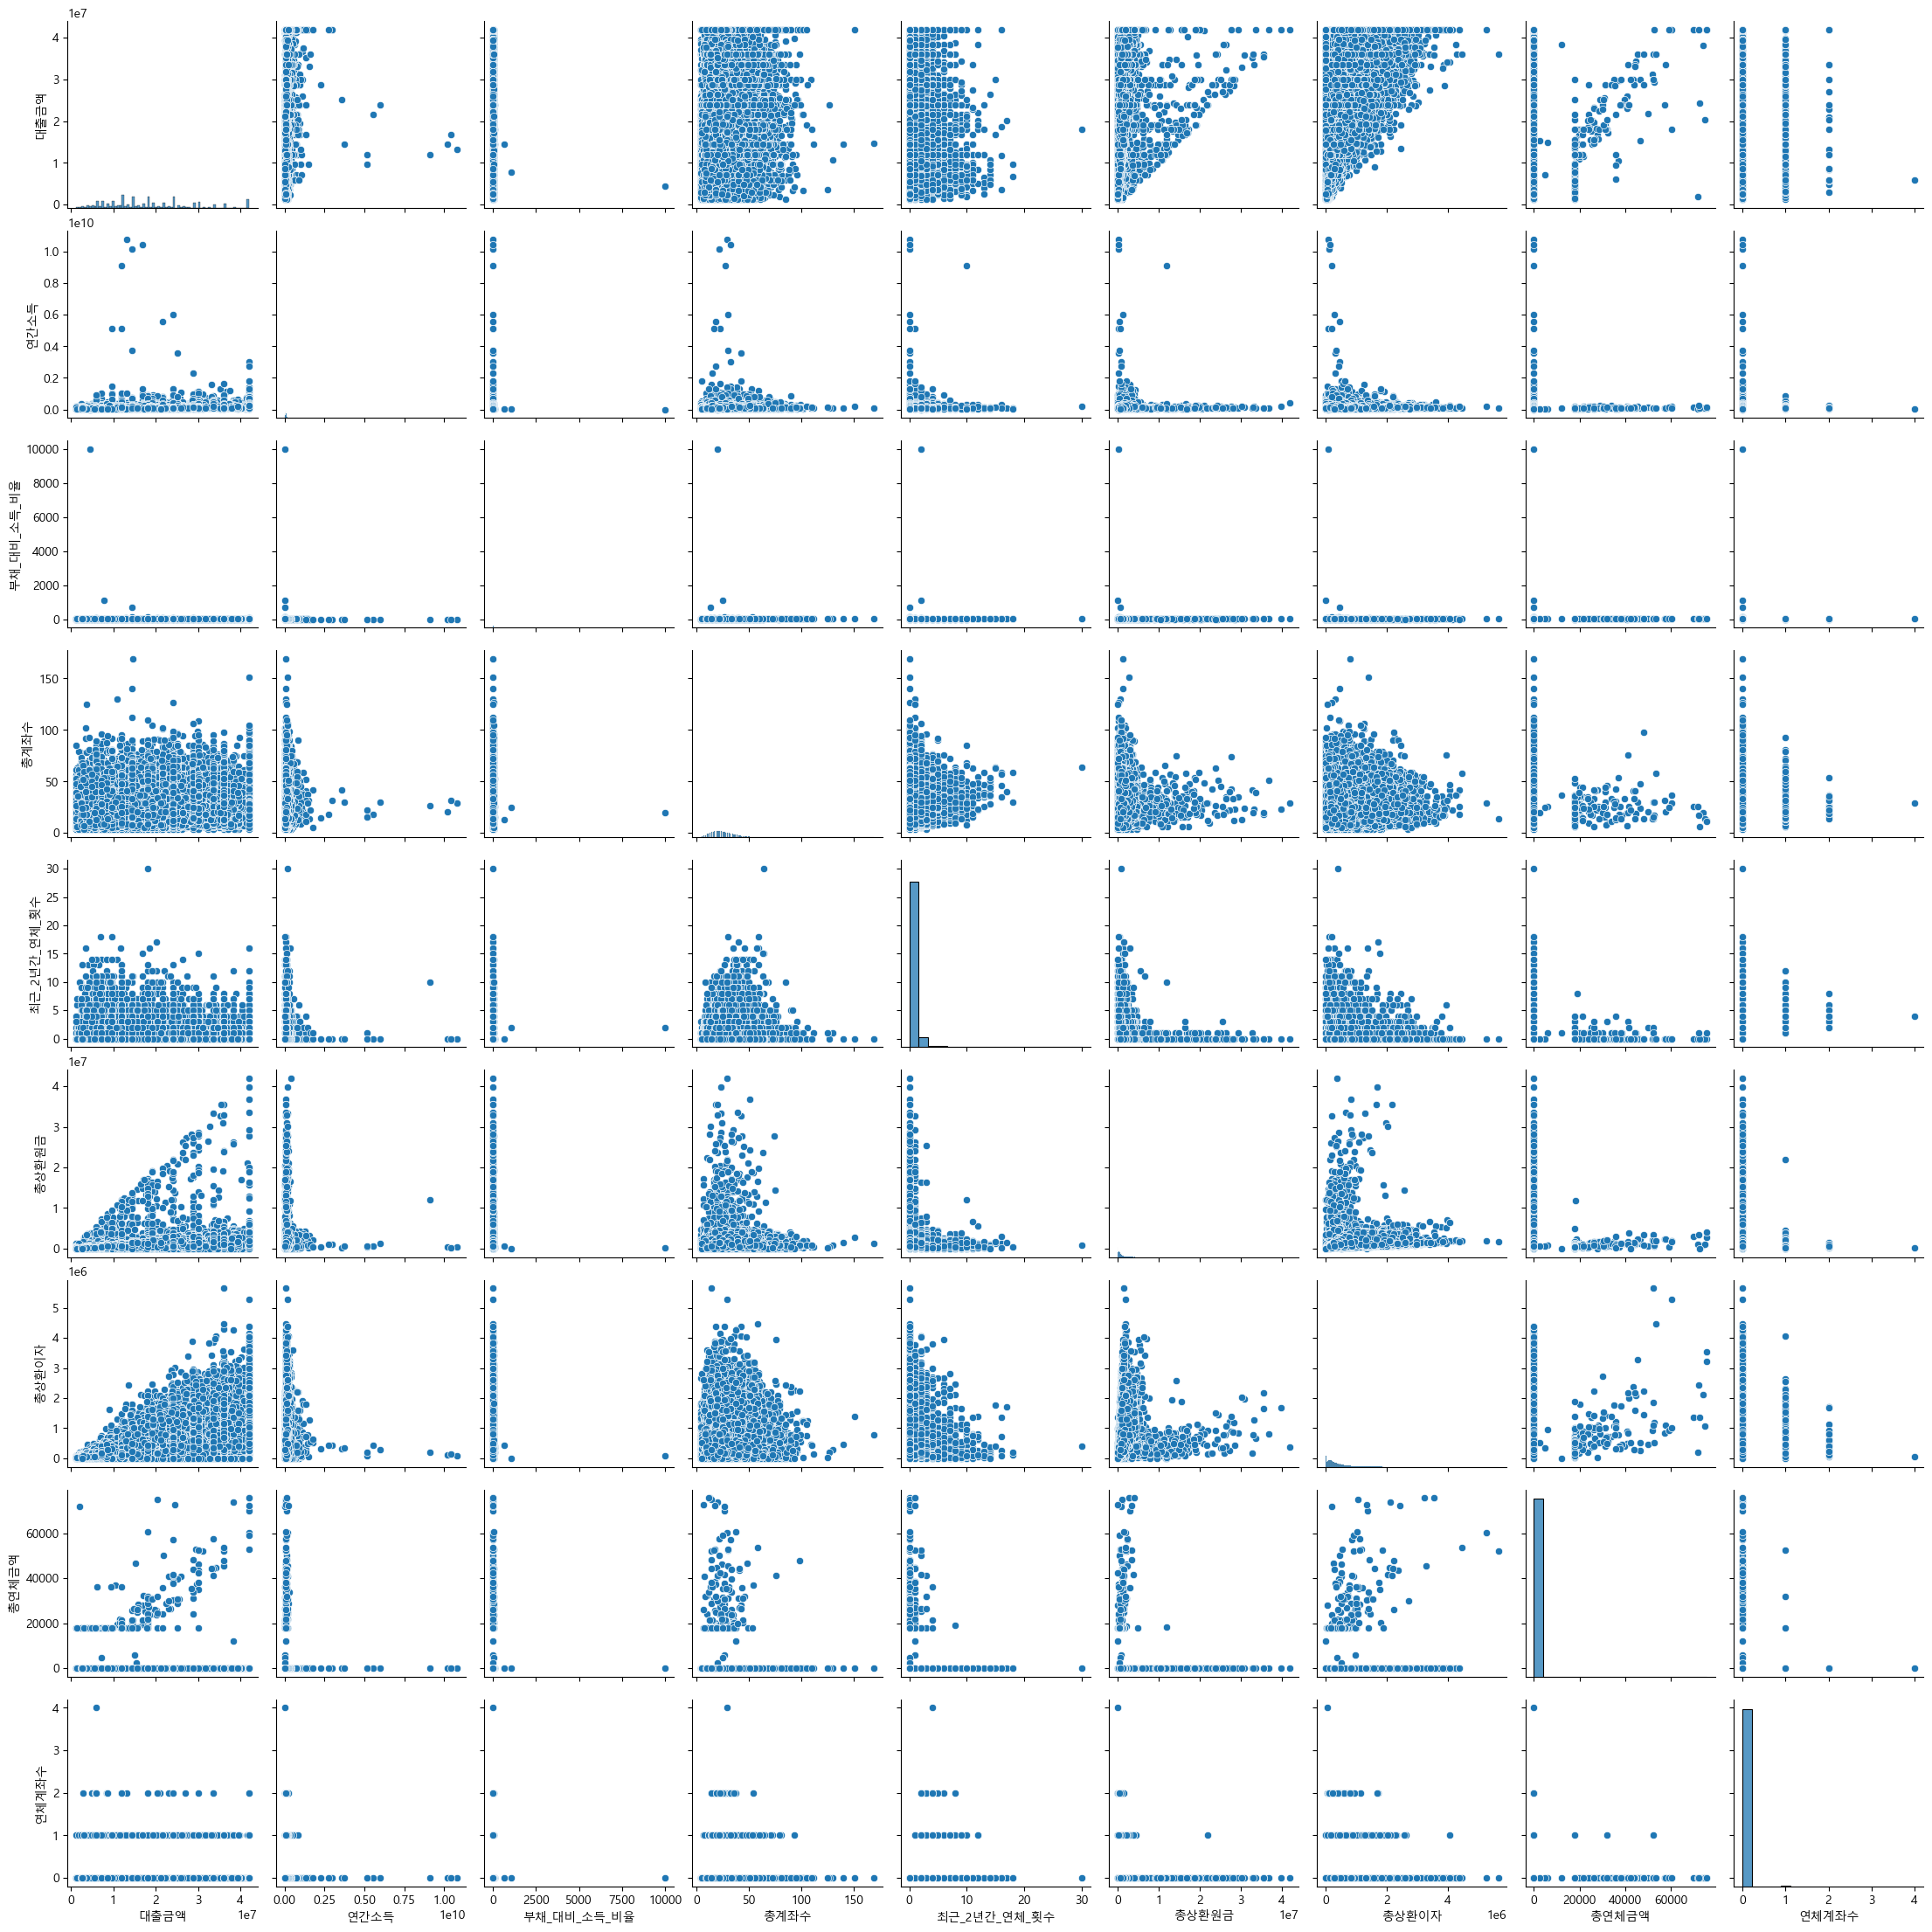

In [156]:
sns.pairplot(train[numeric_columns])
plt.show()

## 3. Feature Engineering


#### 1. Feature Engineering - Numerical Variable


##### Missing Value 찾기


In [157]:
count_na = train.isna().sum()
count_na

ID              0
대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
대출등급            0
dtype: int64

<AxesSubplot: >

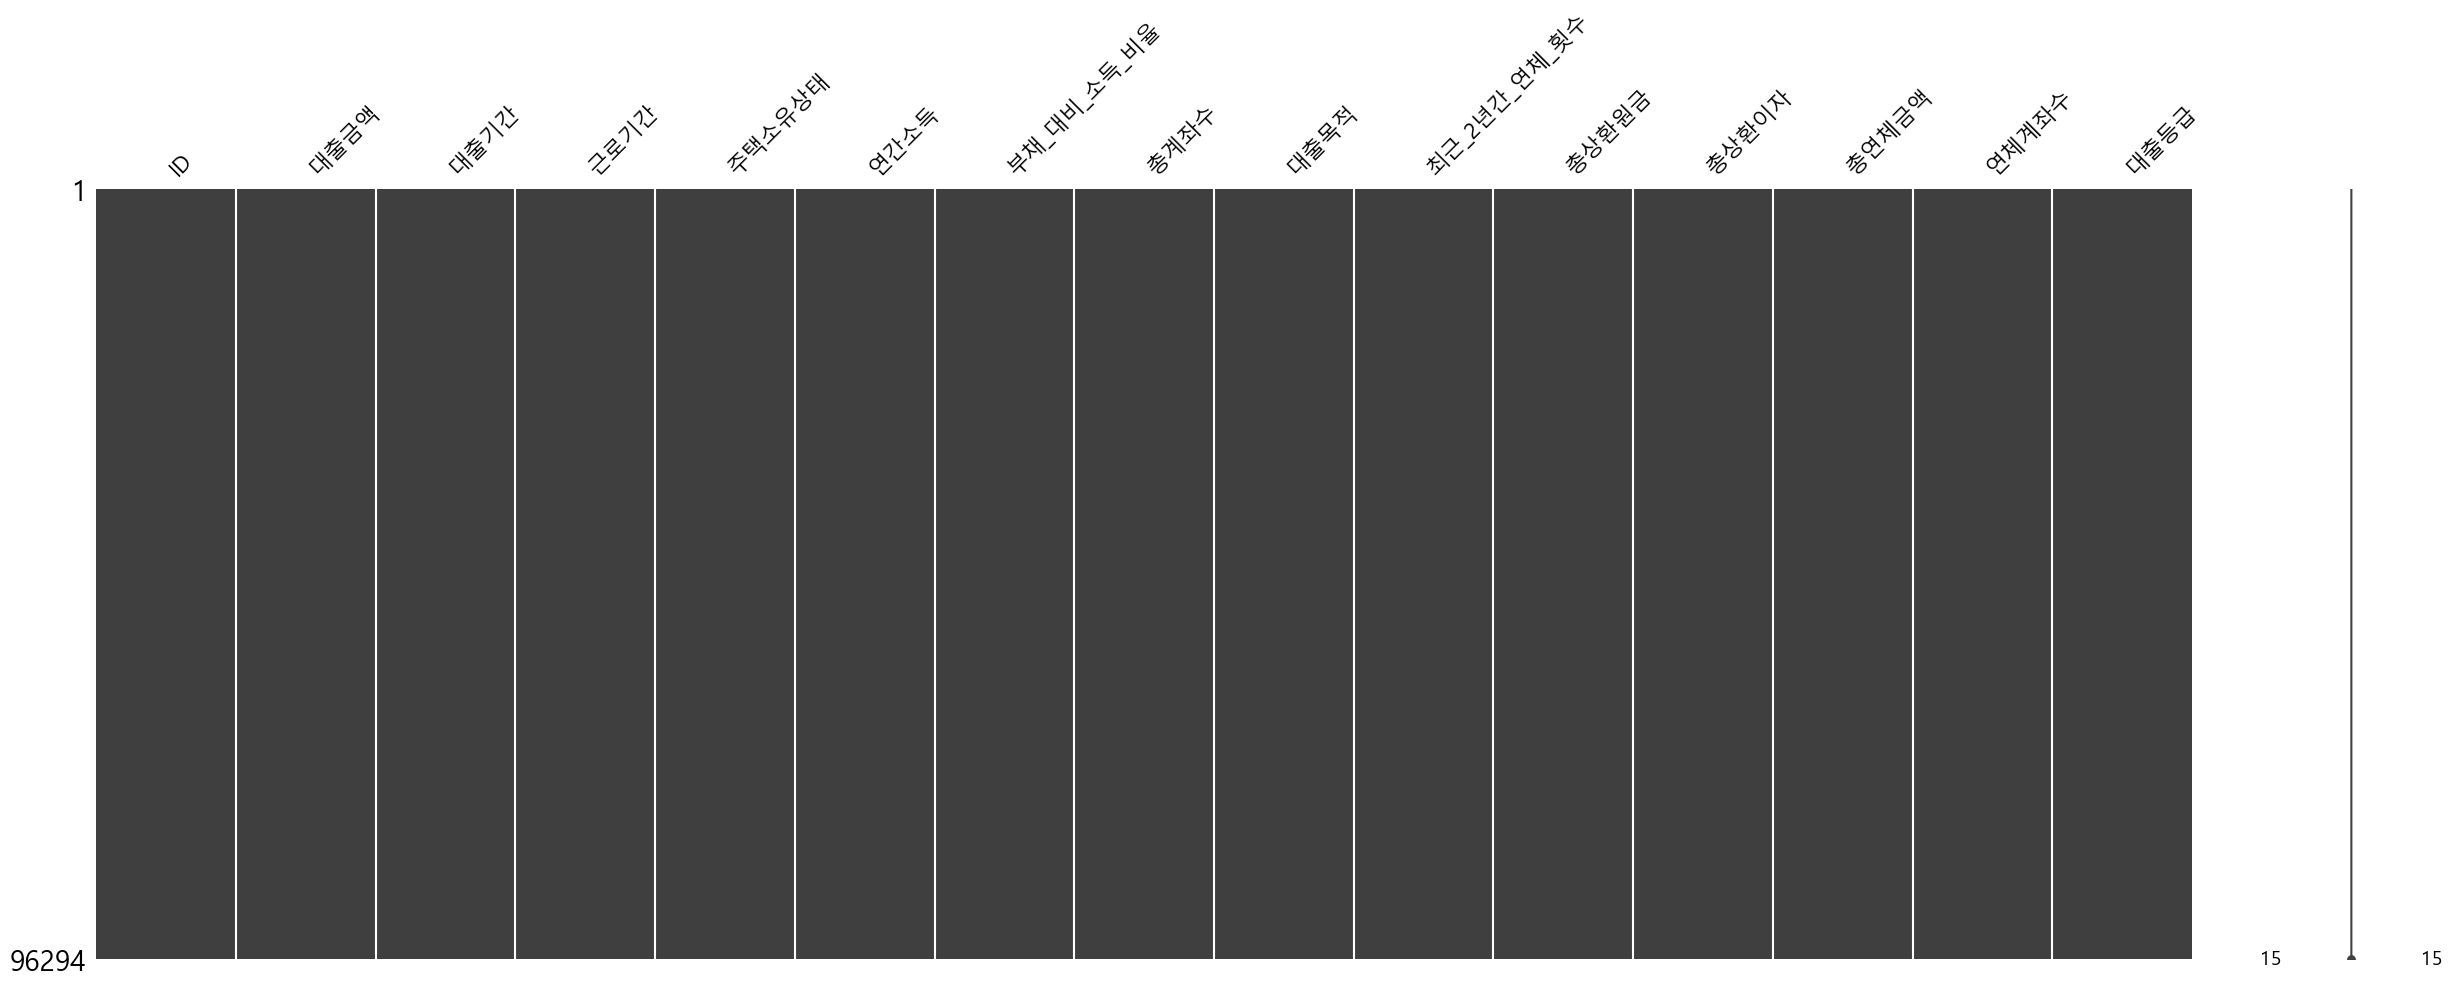

In [158]:
import missingno
missingno.matrix(train, figsize=(30, 10))

In [159]:
count_na2 = test.isna().sum()
count_na2

ID              0
대출금액            0
대출기간            0
근로기간            0
주택소유상태          0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
대출목적            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
dtype: int64

<AxesSubplot: >

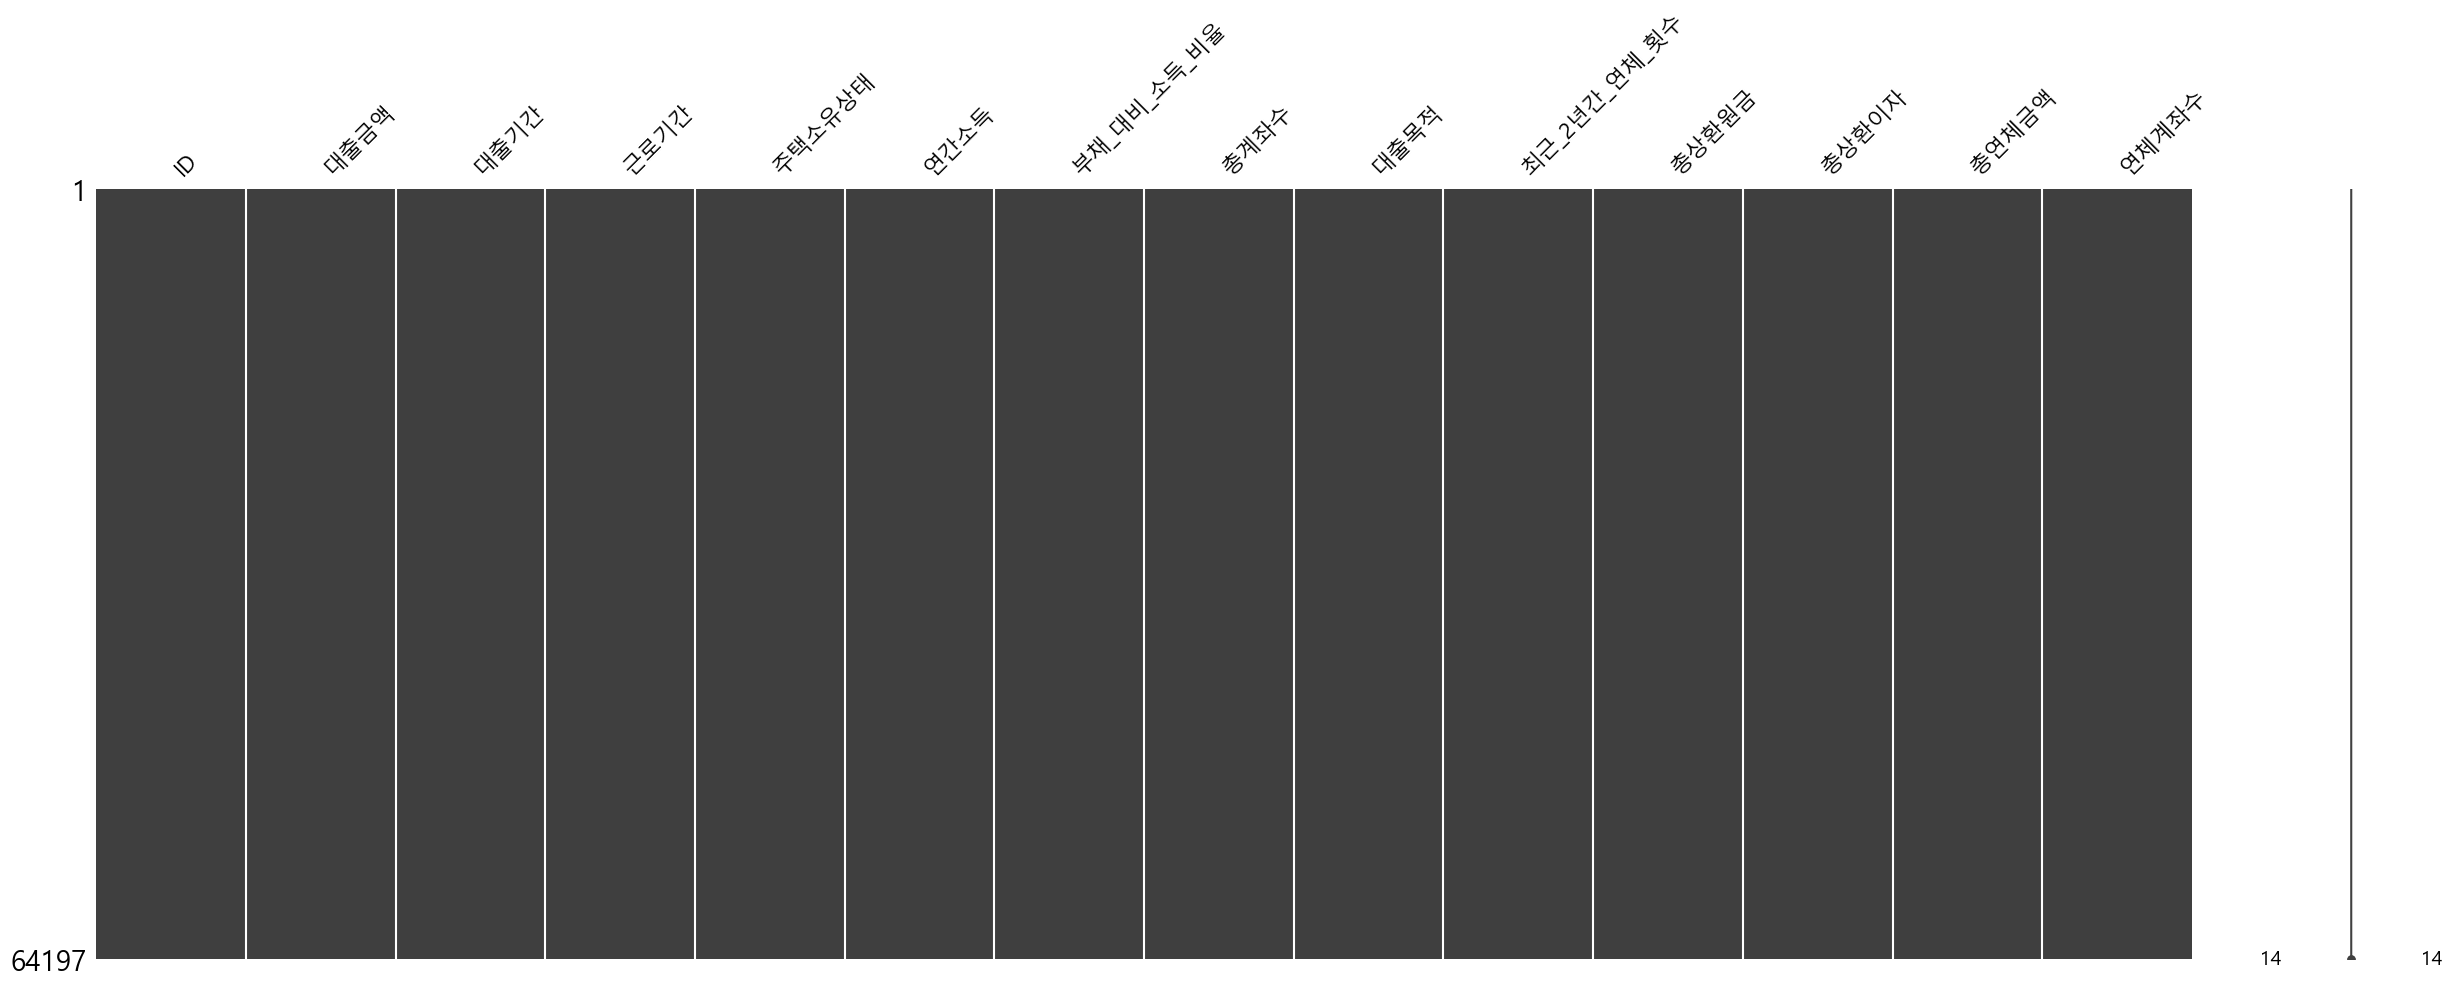

In [160]:
missingno.matrix(test, figsize=(30, 10))

##### 중복된 행 여부 찾기


In [161]:
train.duplicated().sum()

0

In [162]:
test.duplicated().sum()

0

##### 이상치 확인


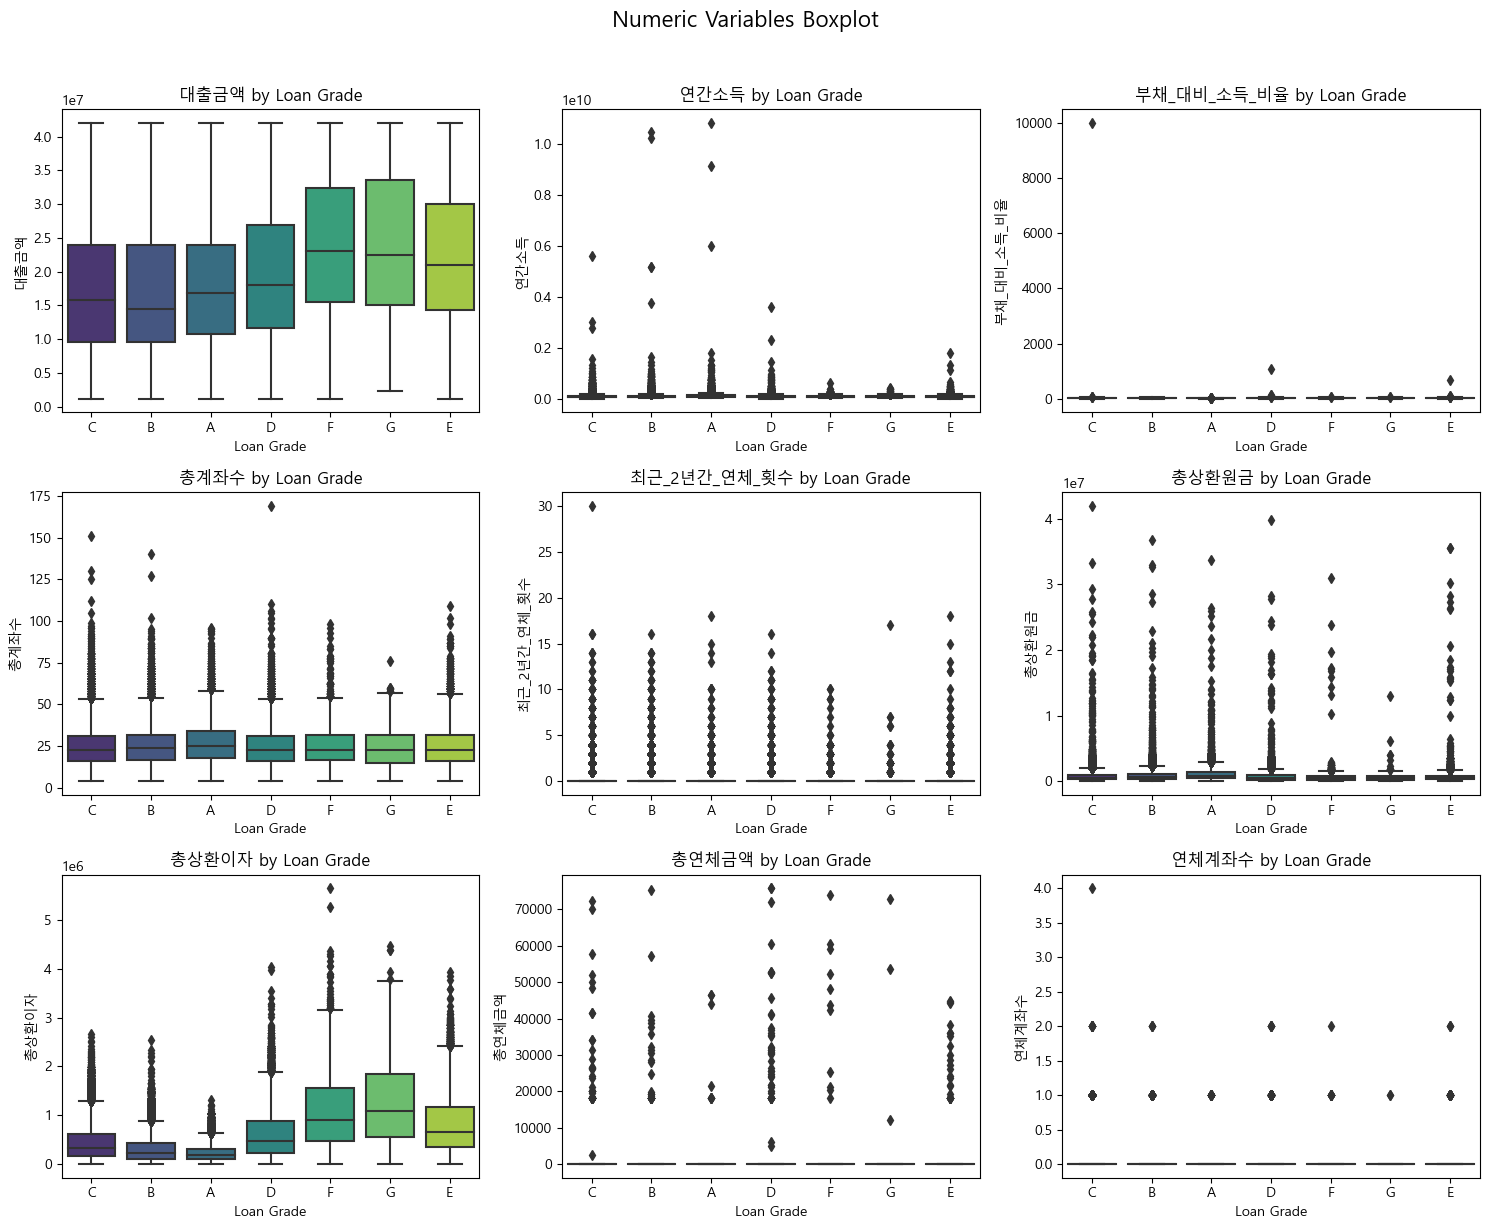

In [163]:
numeric_columns = train.select_dtypes(include=["number"]).columns

# Set up the visualization
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 12))
fig.suptitle("Numeric Variables Boxplot", y=1.02, fontsize=16)

# Visualize the distribution of numeric variables grouped by loan grade
for i in range(3):
    for j, col in enumerate(numeric_columns[i * 3: i * 3 + 3]):
        sns.boxplot(data=train, x="대출등급", y=col,
                    ax=axes[i, j], palette="viridis")

        # Set title and labels for each subplot
        axes[i, j].set_title(f"{col} by Loan Grade")
        axes[i, j].set_xlabel("Loan Grade")
        axes[i, j].set_ylabel(col)

# Adjust layout for better visualization
plt.tight_layout()
plt.show()

#### 2. Feature Engineering - Categorical Varible


In [164]:
cat_col = train.select_dtypes(include=["object", "category"]).columns.tolist()
cat_col

['ID', '대출기간', '근로기간', '주택소유상태', '대출목적', '대출등급']

##### One-Hot Encoding


In [165]:
# Initialize OneHotEncoder with specified parameters
home_ownership_encoder = OneHotEncoder(sparse=False, drop="first")

# Apply one-hot encoding to the "주택소유상태" column in the training set
home_ownership_encoded = home_ownership_encoder.fit_transform(
    train[["주택소유상태"]])

# Concatenate the encoded columns to the original DataFrame for the training set
train_encoded = pd.concat([train, pd.DataFrame(
    home_ownership_encoded, columns=["RENT", "OWN", "ANY"])], axis=1)

# Apply one-hot encoding to the "주택소유상태" column in the test set
home_ownership_encoded_test = home_ownership_encoder.transform(
    test[["주택소유상태"]])

# Concatenate the encoded columns to the original DataFrame for the test set
test_encoded = pd.concat([test, pd.DataFrame(
    home_ownership_encoded_test, columns=["RENT", "OWN", "ANY"])], axis=1)

# Drop the original "주택소유상태" column from both the training and test sets
train.drop("주택소유상태", axis=1, inplace=True)
test.drop("주택소유상태", axis=1, inplace=True)

In [166]:
# Initialize OneHotEncoder with specified parameters
loan_purpose_encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")

# Apply one-hot encoding to the "대출목적" column in the training set
loan_purpose_encoded_train = loan_purpose_encoder.fit_transform(train[[
                                                                "대출목적"]])

# Apply one-hot encoding to the "대출목적" column in the test set
loan_purpose_encoded_test = loan_purpose_encoder.transform(test[["대출목적"]])

# Concatenate the encoded columns to the original DataFrame for the training set
train = pd.concat(
    [
        train,
        pd.DataFrame(
            loan_purpose_encoded_train,
            columns=loan_purpose_encoder.get_feature_names_out(["대출목적"]),
        ),
    ],
    axis=1,
)

# Concatenate the encoded columns to the original DataFrame for the test set
test = pd.concat(
    [
        test,
        pd.DataFrame(
            loan_purpose_encoded_test,
            columns=loan_purpose_encoder.get_feature_names_out(["대출목적"]),
        ),
    ],
    axis=1,
)

# Drop the original "대출목적" column from both the training and test sets
train.drop("대출목적", axis=1, inplace=True)
test.drop("대출목적", axis=1, inplace=True)

##### Ordinal Encoder


In [167]:
# Initialize the OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

# Apply ordinal encoding to the "대출기간" column in the training set
train["대출기간"] = ordinal_encoder.fit_transform(train[["대출기간"]])

# Apply ordinal encoding to the "대출기간" column in the test set
test["대출기간"] = ordinal_encoder.transform(test[["대출기간"]])

In [168]:
# Define the mapping dictionary for employment length
employment_mapping = {
    "Unknown": 0,
    "1 years": 1,
    "2 years": 2,
    "3 years": 3,
    "4 years": 4,
    "5 years": 5,
    "6 years": 6,
    "7 years": 7,
    "8 years": 8,
    "9 years": 9,
    "10+ years": 10,
}

# Apply the mapping to the "근로기간" column in the training set
train["근로기간"] = train["근로기간"].map(employment_mapping)

# Apply the mapping to the "근로기간" column in the test set
test["근로기간"] = test["근로기간"].map(employment_mapping)

In [169]:
# Define the mapping dictionary for loan grade
grade_mapping = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4, "F": 5, "G": 6}

# Apply the mapping to the "대출등급" column in the training set
train["대출등급"] = train["대출등급"].map(grade_mapping)

In [170]:
train.head()

,ID,대출금액,대출기간,근로기간,연간소득,부채_대비_소득_비율,총계좌수,최근_2년간_연체_횟수,총상환원금,총상환이자,...,대출목적_소규모 사업,대출목적_신용 카드,대출목적_의료,대출목적_이사,대출목적_자동차,대출목적_재생 에너지,대출목적_주요 구매,대출목적_주택,대출목적_주택 개선,대출목적_휴가
0,TRAIN_00000,12480000,0.0,6,72000000,18.90,15,0,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,TRAIN_00001,14400000,1.0,10,130800000,22.33,21,0,373572,234060.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,TRAIN_00002,12000000,0.0,5,96000000,8.60,14,0,928644,151944.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,TRAIN_00003,14400000,0.0,8,132000000,15.09,15,0,325824,153108.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,TRAIN_00004,18000000,1.0,0,71736000,25.39,19,0,228540,148956.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [171]:
train.shape

(96294, 25)

In [172]:
test.shape

(64197, 24)

In [173]:
count_na = train.isna().sum()
count_na

ID              0
대출금액            0
대출기간            0
근로기간            0
연간소득            0
부채_대비_소득_비율     0
총계좌수            0
최근_2년간_연체_횟수    0
총상환원금           0
총상환이자           0
총연체금액           0
연체계좌수           0
대출등급            0
대출목적_기타         0
대출목적_부채 통합      0
대출목적_소규모 사업     0
대출목적_신용 카드      0
대출목적_의료         0
대출목적_이사         0
대출목적_자동차        0
대출목적_재생 에너지     0
대출목적_주요 구매      0
대출목적_주택         0
대출목적_주택 개선      0
대출목적_휴가         0
dtype: int64

## 4. Data Splitting


In [174]:
# Drop the "ID" column from the training data
train = train.drop("ID", axis=1)

# Separate features (X) and target variable (y)
X, y = train.drop("대출등급", axis=1).copy(), train["대출등급"].copy()

In [175]:
train["대출등급"].value_counts()

1    28817
2    27623
0    16772
3    13354
4     7354
5     1954
6      420
Name: 대출등급, dtype: int64

The code train["대출등급"].value_counts() is used to quickly check for data imbalance in the "대출등급" (Loan Grade) column. It helps assess whether there is an uneven distribution of instances across different loan grades in the dataset, which is crucial for addressing potential biases in machine learning models.


#### 1. Oversampling

Over-sampling is a technique used to address class imbalance in machine learning datasets by increasing the number of instances in the minority class. The goal is to create a more balanced dataset, preventing the model from being biased towards the majority class. Various over-sampling methods exist, and one common approach is the Synthetic Minority Over-sampling Technique (SMOTE).


In [176]:
# Create an instance of SMOTE with a specified random seed
smote = SMOTE(random_state=42)

# Apply SMOTE to the training data to perform oversampling
X_train_resampled, y_train_resampled = smote.fit_resample(X, y)

#### 2. Undersampling

Under-sampling is another technique used to address class imbalance in machine learning datasets. Unlike over-sampling, under-sampling focuses on reducing the number of instances in the majority class to achieve a more balanced dataset.


In [177]:
# rus = RandomUnderSampler(random_state=10)
# X_train_resampled, y_train_resampled = rus.fit_resample(X, y)

#### Decision

The performance improvement achieved by oversampling was evident, as the model trained on the oversampled data consistently exhibited better results. With oversampling techniques like SMOTE applied to balance the class distribution, the model demonstrated enhanced predictive accuracy and effectiveness in handling imbalanced data, contributing to overall improved performance on the task of predicting loan grades.


##### Split the data


In [178]:
# Split the resampled training data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_train_resampled, y_train_resampled, test_size=0.3, random_state=10
)

In [179]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(141203, 23)
(141203,)
(60516, 23)
(60516,)


##### Data Scaling

After experimenting with various scalers, including RobustScaler and StandardScaler, I found that MinMaxScaler consistently produced the best performance for my dataset. As a result, I opted to use MinMaxScaler for feature scaling in my machine learning workflow.


In [180]:
# # Create an instance of StandardScaler
# scaler = StandardScaler()

# # Fit and transform the training data
# X_train_scaled = scaler.fit_transform(X_train)

# # Transform the test data using the same scaler
# X_test_scaled = scaler.transform(X_test)

In [181]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test data using the same scaler
X_test_scaled = scaler.transform(X_test)

In [182]:
# scaler = RobustScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

## 5. Training and Evaluating the Model


In [183]:
def evaluate_model(X_train, y_train, X_test, y_test, model):
    # Train the model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_test_pred = model.predict(X_test)

    # Calculate test accuracy
    test_accuracy = accuracy_score(y_test, y_test_pred)
    print(f"Test accuracy for {model}: {test_accuracy}")

    # Confusion Matrix calculation
    cm = confusion_matrix(y_test, y_test_pred)

    # Calculate True Positives, False Negatives, False Positives, and True Negatives
    TP = np.diag(cm)
    FN = np.sum(cm, axis=1) - TP
    FP = np.sum(cm, axis=0) - TP
    total = np.sum(cm)
    TN = total - (TP + FN + FP)

    # Display metrics for each class
    for i in range(len(TP)):
        print(f"Class {i + 1}: TP={TP[i]}, FN={FN[i]}, FP={FP[i]}, TN={TN[i]}")

    # Visualize Confusion Matrix using heatmap
    sns.heatmap(cm, annot=True, cmap="rainbow")

    # Display classification report
    print(classification_report(y_test, y_test_pred))

#### DecisionTreeClassifier


##### Hyperparameter tuning

Note: Hyperparameter tuning for other models was not completed due to significant time constraints.

The DecisionTreeClassifier is the only model for which hyperparameter tuning was performed.


In [184]:
# Training and Evaluating the DecisionTreeClassifier

# DecisionTreeClassifier model initialization
dt_model = DecisionTreeClassifier(random_state=10)

# Candidate values for hyperparameters (max_depth and min_samples_split)
param_grid = {
    "min_samples_split": [50, 100, 200],
    "max_depth": [10, 50, 100, 200, None],
}

# GridSearchCV to perform cross-validated hyperparameter tuning
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_resampled, y_train_resampled)

# Output the best hyperparameters
best_params = grid_search.best_params_
best_max_depth = grid_search.best_params_["max_depth"]
best_min_samples_split = grid_search.best_params_["min_samples_split"]
print(f"Best hyperparameters: {best_params}")

Best hyperparameters: {'max_depth': 50, 'min_samples_split': 50}


Test accuracy for DecisionTreeClassifier(max_depth=50, min_samples_split=50, random_state=10): 0.8320278934496662
Class 1: TP=7719, FN=808, FP=927, TN=51062
Class 2: TP=7189, FN=1511, FP=1559, TN=50257
Class 3: TP=7037, FN=1568, FP=1677, TN=50234
Class 4: TP=6535, FN=2179, FP=2135, TN=49667
Class 5: TP=6604, FN=2071, FP=1942, TN=49899
Class 6: TP=7285, FN=1316, FP=1284, TN=50631
Class 7: TP=7982, FN=712, FP=641, TN=51181
              precision    recall  f1-score   support

           0       0.89      0.91      0.90      8527
           1       0.82      0.83      0.82      8700
           2       0.81      0.82      0.81      8605
           3       0.75      0.75      0.75      8714
           4       0.77      0.76      0.77      8675
           5       0.85      0.85      0.85      8601
           6       0.93      0.92      0.92      8694

    accuracy                           0.83     60516
   macro avg       0.83      0.83      0.83     60516
weighted avg       0.83      0.83

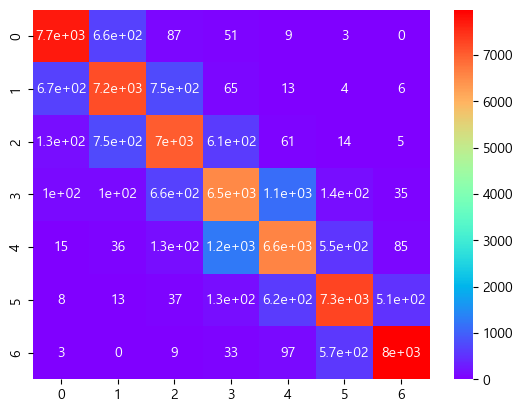

In [185]:
# Initialize a DecisionTreeClassifier with the best hyperparameters obtained from hyperparameter tuning
dt_model = DecisionTreeClassifier(
    random_state=10, max_depth=best_max_depth, min_samples_split=best_min_samples_split
)

# Evaluate the performance of the DecisionTreeClassifier on the scaled training and test sets
evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, dt_model)

#### RandomForestClassifier


Test accuracy for RandomForestClassifier(random_state=10): 0.8650935289840703
Class 1: TP=7682, FN=845, FP=779, TN=51210
Class 2: TP=7057, FN=1643, FP=1860, TN=49956
Class 3: TP=6999, FN=1606, FP=2227, TN=49684
Class 4: TP=6543, FN=2171, FP=1662, TN=50140
Class 5: TP=7142, FN=1533, FP=1244, TN=50597
Class 6: TP=8272, FN=329, FP=311, TN=51604
Class 7: TP=8657, FN=37, FP=81, TN=51741
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      8527
           1       0.79      0.81      0.80      8700
           2       0.76      0.81      0.79      8605
           3       0.80      0.75      0.77      8714
           4       0.85      0.82      0.84      8675
           5       0.96      0.96      0.96      8601
           6       0.99      1.00      0.99      8694

    accuracy                           0.87     60516
   macro avg       0.87      0.87      0.87     60516
weighted avg       0.87      0.87      0.87     60516



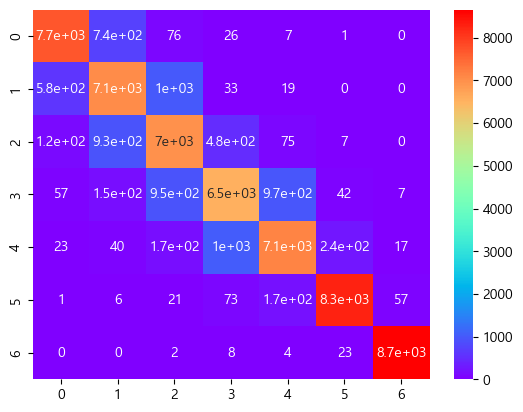

In [186]:
# Initialize a RandomForestClassifier with a specific random seed
rf_model = RandomForestClassifier(random_state=10)

# Evaluate the performance of the RandomForestClassifier on the scaled training and test sets
evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, rf_model)

#### GradientBoostingClassifier


Test accuracy for GradientBoostingClassifier(random_state=10): 0.7109524753784123
Class 1: TP=7526, FN=1001, FP=836, TN=51153
Class 2: TP=6495, FN=2205, FP=2618, TN=49198
Class 3: TP=6092, FN=2513, FP=4587, TN=47324
Class 4: TP=3306, FN=5408, FP=2822, TN=48980
Class 5: TP=5604, FN=3071, FP=4247, TN=47594
Class 6: TP=6529, FN=2072, FP=1545, TN=50370
Class 7: TP=7472, FN=1222, FP=837, TN=50985
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      8527
           1       0.71      0.75      0.73      8700
           2       0.57      0.71      0.63      8605
           3       0.54      0.38      0.45      8714
           4       0.57      0.65      0.60      8675
           5       0.81      0.76      0.78      8601
           6       0.90      0.86      0.88      8694

    accuracy                           0.71     60516
   macro avg       0.71      0.71      0.71     60516
weighted avg       0.71      0.71      0.71     60516



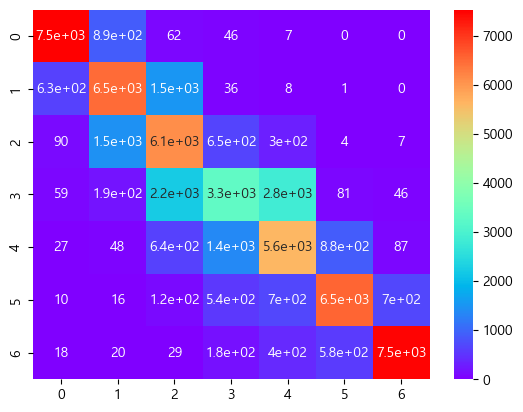

In [187]:
# Initialize a GradientBoostingClassifier with specified hyperparameters
gb_model = GradientBoostingClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, subsample=1.0, random_state=10
)

# Evaluate the performance of the GradientBoostingClassifier on the scaled training and test sets
evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, gb_model)

#### AdaBoostClassifier


Test accuracy for AdaBoostClassifier(): 0.439767995240928
Class 1: TP=6216, FN=2311, FP=2684, TN=49305
Class 2: TP=3932, FN=4768, FP=4471, TN=47345
Class 3: TP=3386, FN=5219, FP=5282, TN=46629
Class 4: TP=3153, FN=5561, FP=5289, TN=46513
Class 5: TP=4866, FN=3809, FP=10288, TN=41553
Class 6: TP=1814, FN=6787, FP=3995, TN=47920
Class 7: TP=3246, FN=5448, FP=1894, TN=49928
              precision    recall  f1-score   support

           0       0.70      0.73      0.71      8527
           1       0.47      0.45      0.46      8700
           2       0.39      0.39      0.39      8605
           3       0.37      0.36      0.37      8714
           4       0.32      0.56      0.41      8675
           5       0.31      0.21      0.25      8601
           6       0.63      0.37      0.47      8694

    accuracy                           0.44     60516
   macro avg       0.46      0.44      0.44     60516
weighted avg       0.46      0.44      0.44     60516



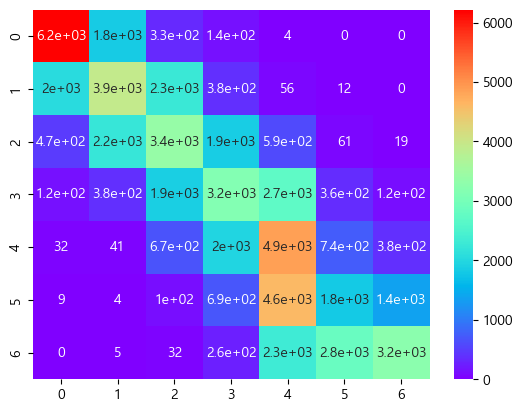

In [188]:
ada_model = AdaBoostClassifier()
evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, ada_model)

#### KNeighborsClassifier


Test accuracy for KNeighborsClassifier(): 0.4990746248925904
Class 1: TP=6056, FN=2471, FP=5037, TN=46952
Class 2: TP=3609, FN=5091, FP=6038, TN=45778
Class 3: TP=2880, FN=5725, FP=5019, TN=46892
Class 4: TP=2445, FN=6269, FP=4308, TN=47494
Class 5: TP=3002, FN=5673, FP=4075, TN=47766
Class 6: TP=4805, FN=3796, FP=3095, TN=48820
Class 7: TP=7405, FN=1289, FP=2742, TN=49080
              precision    recall  f1-score   support

           0       0.55      0.71      0.62      8527
           1       0.37      0.41      0.39      8700
           2       0.36      0.33      0.35      8605
           3       0.36      0.28      0.32      8714
           4       0.42      0.35      0.38      8675
           5       0.61      0.56      0.58      8601
           6       0.73      0.85      0.79      8694

    accuracy                           0.50     60516
   macro avg       0.49      0.50      0.49     60516
weighted avg       0.49      0.50      0.49     60516



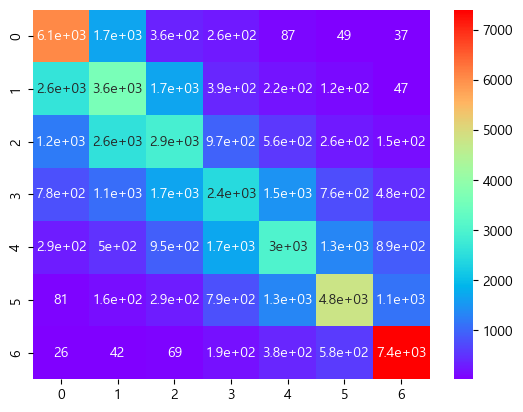

In [189]:
knn_model = KNeighborsClassifier()
evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, knn_model)

#### LogisticRegression


Test accuracy for LogisticRegression(max_iter=10000, random_state=10): 0.3966554299689338
Class 1: TP=7069, FN=1458, FP=6030, TN=45959
Class 2: TP=2749, FN=5951, FP=5423, TN=46393
Class 3: TP=2099, FN=6506, FP=5268, TN=46643
Class 4: TP=1521, FN=7193, FP=3197, TN=48605
Class 5: TP=2528, FN=6147, FP=6946, TN=44895
Class 6: TP=2517, FN=6084, FP=5217, TN=46698
Class 7: TP=5521, FN=3173, FP=4431, TN=47391
              precision    recall  f1-score   support

           0       0.54      0.83      0.65      8527
           1       0.34      0.32      0.33      8700
           2       0.28      0.24      0.26      8605
           3       0.32      0.17      0.23      8714
           4       0.27      0.29      0.28      8675
           5       0.33      0.29      0.31      8601
           6       0.55      0.64      0.59      8694

    accuracy                           0.40     60516
   macro avg       0.38      0.40      0.38     60516
weighted avg       0.38      0.40      0.38     60516

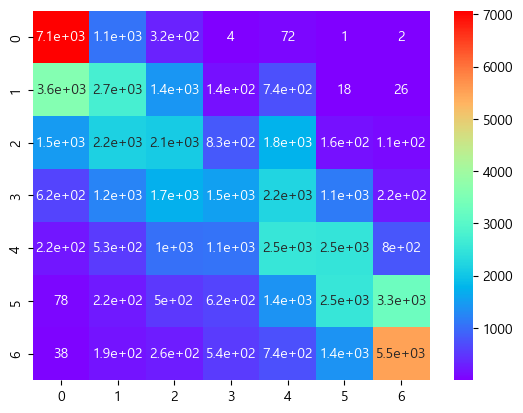

In [190]:
lg_model = LogisticRegression(random_state=10, max_iter=10000)
evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, lg_model)

#### XGBClassifier


Test accuracy for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...): 0.6394672483310199
Class 1: TP=7726, FN=801, FP=1677, TN=50312
Class 2: TP=6248, FN=2452, FP=3907, TN=47909
Class 3: TP=4651, FN=3954, FP=4649, TN=47262
Class 4: TP=2299, FN=6415, FP=1935, TN=49867
Class 5: TP=4199, FN=

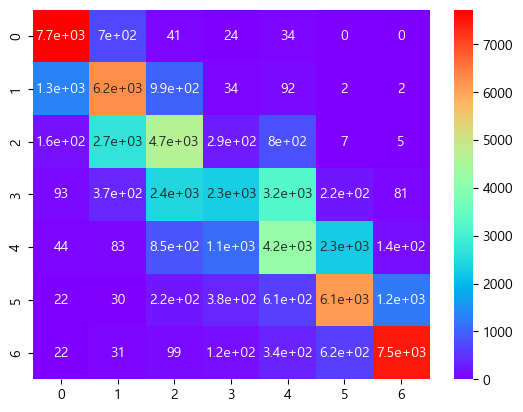

In [191]:
xgb_model = XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=10
)
evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, xgb_model)

#### CatBoostClassifier


0:	learn: 1.8464861	total: 57.5ms	remaining: 5.69s
1:	learn: 1.7698165	total: 104ms	remaining: 5.09s
2:	learn: 1.7134126	total: 151ms	remaining: 4.87s
3:	learn: 1.6642329	total: 197ms	remaining: 4.72s
4:	learn: 1.6242395	total: 244ms	remaining: 4.64s
5:	learn: 1.5846030	total: 286ms	remaining: 4.48s
6:	learn: 1.5447981	total: 330ms	remaining: 4.38s
7:	learn: 1.5118040	total: 374ms	remaining: 4.3s
8:	learn: 1.4792923	total: 419ms	remaining: 4.24s
9:	learn: 1.4447162	total: 464ms	remaining: 4.18s
10:	learn: 1.4177939	total: 512ms	remaining: 4.15s
11:	learn: 1.3905089	total: 556ms	remaining: 4.08s
12:	learn: 1.3655100	total: 599ms	remaining: 4.01s
13:	learn: 1.3432158	total: 646ms	remaining: 3.97s
14:	learn: 1.3231920	total: 687ms	remaining: 3.9s
15:	learn: 1.3030655	total: 731ms	remaining: 3.83s
16:	learn: 1.2891698	total: 768ms	remaining: 3.75s
17:	learn: 1.2740245	total: 808ms	remaining: 3.68s
18:	learn: 1.2585503	total: 850ms	remaining: 3.62s
19:	learn: 1.2436402	total: 891ms	remainin

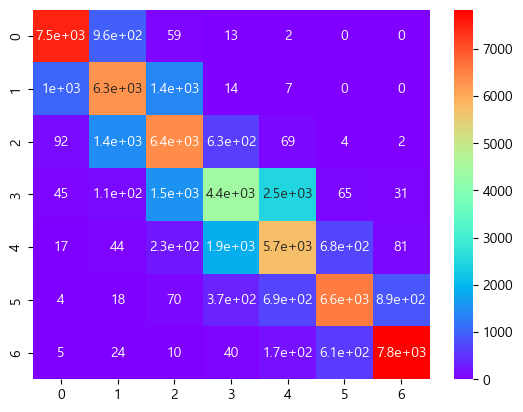

In [192]:
catboost_model = CatBoostClassifier(
    iterations=100, learning_rate=0.1, depth=6, random_state=10
)
evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, catboost_model)

#### LGBMClassifier


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003021 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5028
[LightGBM] [Info] Number of data points in the train set: 141203, number of used features: 23
[LightGBM] [Info] Start training from score -1.940070
[LightGBM] [Info] Start training from score -1.948633
[LightGBM] [Info] Start training from score -1.943922
[LightGBM] [Info] Start training from score -1.949330
[LightGBM] [Info] Start training from score -1.947391
[LightGBM] [Info] Start training from score -1.943724
[LightGBM] [Info] Start training from score -1.948335
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with

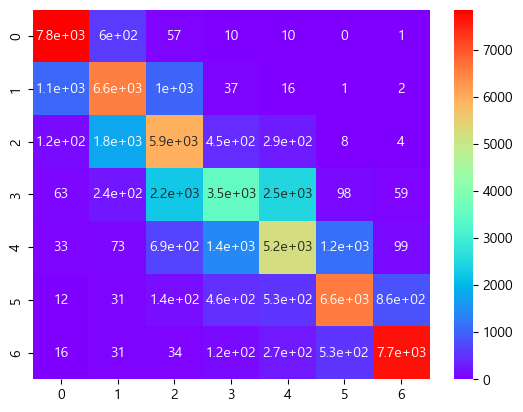

In [193]:
lgbm_model = lgb.LGBMClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=3, random_state=10
)
evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, lgbm_model)

After training various models, including Decision Tree, Gradient Boosting, AdaBoost, and XGBoost..., the random forest classifier consistently demonstrated the highest test accuracy of 86.51%. In addition to accuracy, the model's performance was assessed using precision, recall, and F1-score for each class. Across multiple metrics and classes, the random forest classifier consistently outperformed other models, making it the top-performing model for predicting loan grades on the test data.


## 6. Predict "대출등급" with RandomForestClassifier


Test accuracy for RandomForestClassifier(random_state=10): 0.8650935289840703
Class 1: TP=7682, FN=845, FP=779, TN=51210
Class 2: TP=7057, FN=1643, FP=1860, TN=49956
Class 3: TP=6999, FN=1606, FP=2227, TN=49684
Class 4: TP=6543, FN=2171, FP=1662, TN=50140
Class 5: TP=7142, FN=1533, FP=1244, TN=50597
Class 6: TP=8272, FN=329, FP=311, TN=51604
Class 7: TP=8657, FN=37, FP=81, TN=51741
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      8527
           1       0.79      0.81      0.80      8700
           2       0.76      0.81      0.79      8605
           3       0.80      0.75      0.77      8714
           4       0.85      0.82      0.84      8675
           5       0.96      0.96      0.96      8601
           6       0.99      1.00      0.99      8694

    accuracy                           0.87     60516
   macro avg       0.87      0.87      0.87     60516
weighted avg       0.87      0.87      0.87     60516



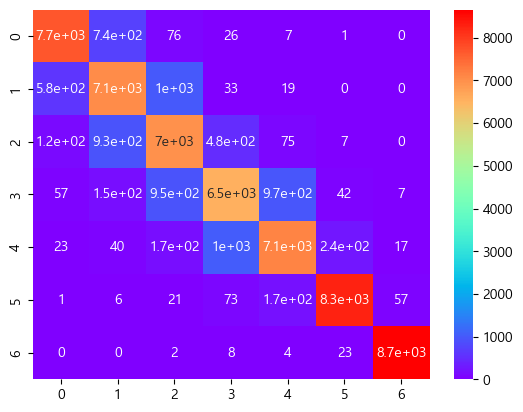

In [194]:
rf_model = RandomForestClassifier(random_state=10)
evaluate_model(X_train_scaled, y_train, X_test_scaled, y_test, rf_model)

In [195]:
# Extract the "ID" column from the test data
id_test = test["ID"]

# Drop the "ID" column from the test data
test = test.drop("ID", axis=1).copy()

In [196]:
# Scale the test data using the same scaler used for training data
test_scaled = scaler.transform(test)

# Make predictions using the trained RandomForestClassifier on the scaled test data
predictions = rf_model.predict(test_scaled)

# Print the predicted labels
print(predictions)

[1 1 0 ... 3 2 0]


In [197]:
# Define a mapping from numeric labels to grade categories
grade_mapping = {0: "A", 1: "B", 2: "C", 3: "D", 4: "E", 5: "F", 6: "G"}

# Create a DataFrame for the submission with "ID" and mapped "대출등급" columns
result_df = pd.DataFrame({"ID": id_test, "대출등급": predictions})

# Map numeric labels to grade categories in the "대출등급" column
result_df["대출등급"] = result_df["대출등급"].map(grade_mapping)

# Save the submission DataFrame to a CSV file without index
result_df.to_csv("result_submission.csv", index=False)